### Let's make some small multiple maps!

Let's see how things have changed overtime with small multiples.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import numpy as np
import os

First let's read in our data and our shapefile.

In [2]:
df = pd.read_csv('data/opiate_deaths.csv', dtype={'INJURY_FIPS':str})

mn_cnty = gpd.read_file('gis/tl_2015_mn_county/tl_2015_mn_county.shp')

In [3]:
df['DEATHDATE'] = pd.to_datetime(df['DEATHDATE'])
df['death_year'] = df['DEATHDATE'].apply(lambda x: x.year)

We need a list of all of the years we'll be using here.

In [4]:
year_list = df['death_year'].unique().tolist()
year_list

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

Now we need to create a pivot table so that we have a death count for each year and each county.

In [5]:
by_yearcnty = pd.pivot_table(df, values='STATEID', index='INJURY_FIPS',
                            columns=['death_year'], aggfunc='count').reset_index()
by_yearcnty

death_year,INJURY_FIPS,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,27001,NaN,NaN,1.0,NaN,2.0,2.0,1.0,1.0,4.0,1.0,3.0,3.0,3.0
1,27003,9.0,9.0,7.0,17.0,16.0,22.0,3.0,15.0,22.0,10.0,14.0,14.0,12.0
2,27005,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,NaN
3,27007,NaN,NaN,2.0,3.0,NaN,1.0,3.0,1.0,1.0,2.0,2.0,3.0,1.0
4,27009,NaN,1.0,2.0,2.0,3.0,3.0,NaN,NaN,1.0,NaN,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,27161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
73,27163,3.0,5.0,1.0,5.0,4.0,3.0,1.0,5.0,8.0,13.0,7.0,8.0,11.0
74,27169,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,5.0,5.0,NaN,3.0,2.0
75,27171,1.0,3.0,NaN,NaN,8.0,3.0,NaN,2.0,7.0,4.0,2.0,1.0,2.0


Next, we're going to merge our year-by-year county data with our shapefile. We join the _data to the shapefile_ instead of joining the _shapefile to the data_ so that all the counties will be represented on our maps, even if they don't have death data for a given year. Otherwise, we would have a swiss cheese map.

In [6]:
yr_geodeaths = mn_cnty.merge(by_yearcnty, left_on='GEOID', right_on='INJURY_FIPS', how='left')

yr_geodeaths = yr_geodeaths.fillna({2005:0,2006:0,2007:0,2008:0,2009:0,2010:0,
                                   2011:0,2012:0,2013:0,2014:0,2015:0,
                                   2016:0,2017:0})

yr_geodeaths

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,27,095,00659493,27095,Mille Lacs,Mille Lacs County,06,H1,G4020,378,...,1.0,4.0,2.0,0.0,2.0,1.0,2.0,1.0,1.0,4.0
1,27,045,00659468,27045,Fillmore,Fillmore County,06,H1,G4020,462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,27,073,00659482,27073,Lac qui Parle,Lac qui Parle County,06,H1,G4020,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,27,085,00659491,27085,McLeod,McLeod County,06,H1,G4020,378,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,27,153,00659521,27153,Todd,Todd County,06,H1,G4020,None,...,1.0,3.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,27,119,00659505,27119,Polk,Polk County,06,H1,G4020,None,...,1.0,0.0,3.0,1.0,2.0,3.0,4.0,1.0,3.0,1.0
83,27,127,00659509,27127,Redwood,Redwood County,06,H1,G4020,None,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,1.0
84,27,055,00659473,27055,Houston,Houston County,06,H1,G4020,None,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,27,019,00659455,27019,Carver,Carver County,06,H1,G4020,378,...,2.0,2.0,3.0,0.0,1.0,4.0,1.0,5.0,2.0,3.0


Now we're going to write a loop that will take each year in our `year_list` and grab the associated column in our pivot table data and map a map using that column.

<module 'matplotlib.pyplot' from '/Users/akanik/.virtualenvs/teaching-guide-data-cleaning-and-viz-with--Yo5GS_kn/lib/python3.7/site-packages/matplotlib/pyplot.py'>

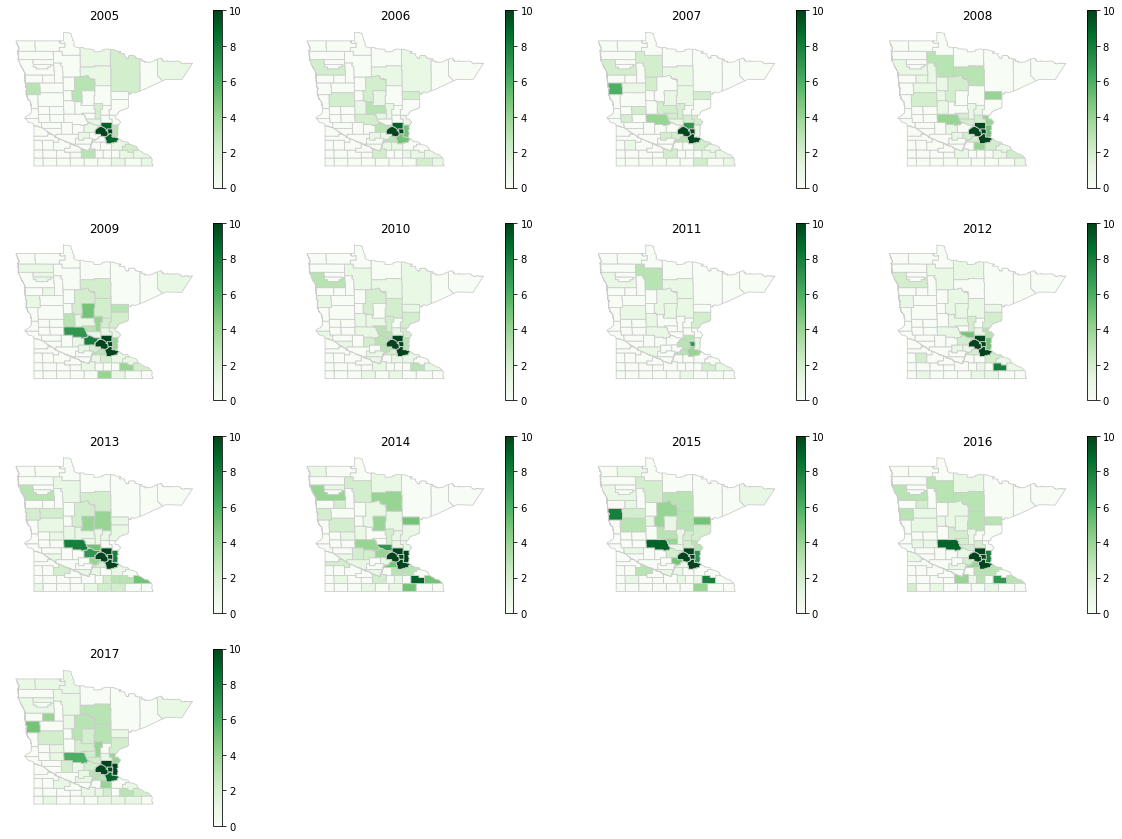

In [7]:
plt.figure(figsize=(20,15), facecolor='white')

plot_number = 1
for year in year_list:
    year = year
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 4, plot_number)
    vmin = 0#yr_geodeaths[year].min
    vmax = 10#yr_geodeaths[year].max
    
    yr_geodeaths.plot(column=year, cmap='Greens', linewidth=0.8, vmin=vmin, 
                      vmax=vmax, edgecolor='0.8',ax=ax, legend=True)
    
    ax.axis('off')
    
    ax.set_title(year, fontdict={'fontsize': '12', 'fontweight' : '3'})
    plot_number = plot_number + 1
plt

There are a few things that are still wrong with this map... the max and min for each map has been manually set. Ideally, we would want to find the largest count of deaths for a given year+county combo and use that as the max. 

Also, we're using just the count of deaths instead of a rate which would be much more useful in determining changes over time.

In [8]:
deaths_by_cnty = df[['INJURY_FIPS','STATEID','death_year']].groupby(['INJURY_FIPS','death_year']).count().reset_index().sort_values('STATEID', ascending=False)
deaths_by_cnty['INJURY_FIPS'] = deaths_by_cnty['INJURY_FIPS'].astype(int).astype(str)
deaths_by_cnty.rename(columns={'STATEID': 'death_count'}, inplace=True)

# add county pop data
cnty_pop = pd.read_csv('data/mn_cnty_pop_estimates.csv')
cnty_pop['cnty_fips'] = cnty_pop['GEO_ID'].apply(lambda x: x[-5:])

# create a new dataframe
cnty_death_pop_merge = deaths_by_cnty.merge(cnty_pop, how='left',
                                            left_on='INJURY_FIPS',
                                            right_on='cnty_fips')

# calculate death rate column per 1,000 residents
cnty_death_pop_merge['death_rate'] = (cnty_death_pop_merge['death_count'] / cnty_death_pop_merge['total_pop'])*1000

# replace those na values with 0s
cnty_death_pop_merge.fillna(value={'death_rate': 0}, inplace=True)

by_yearcnty = pd.pivot_table(cnty_death_pop_merge, values='death_rate', index='INJURY_FIPS',
                            columns=['death_year'], aggfunc='sum').reset_index()

yr_geodeaths = mn_cnty.merge(by_yearcnty, left_on='GEOID', right_on='INJURY_FIPS', how='left')

yr_geodeaths = yr_geodeaths.fillna({2005:0,2006:0,2007:0,2008:0,2009:0,2010:0,
                                   2011:0,2012:0,2013:0,2014:0,2015:0,
                                   2016:0,2017:0})

In [9]:
yr_geodeaths.sort_values(2017, ascending=False)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
71,27,087,00659488,27087,Mahnomen,Mahnomen County,06,H1,G4020,None,...,0.181620,0.181620,0.000000,0.000000,0.000000,0.000000,0.363240,0.181620,0.363240,0.726480
34,27,077,00659483,27077,Lake of the Woods,Lake of the Woods County,06,H1,G4020,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.262536
66,27,069,00659480,27069,Kittson,Kittson County,06,H1,G4020,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230574,0.000000,0.000000,0.230574
6,27,001,00663198,27001,Aitkin,Aitkin County,06,H1,G4020,None,...,0.000000,0.126310,0.126310,0.063155,0.063155,0.252621,0.063155,0.189466,0.189466,0.189466
59,27,031,00659461,27031,Cook,Cook County,06,H1,G4020,None,...,0.000000,0.188288,0.000000,0.000000,0.000000,0.000000,0.000000,0.188288,0.000000,0.188288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,27,079,00659485,27079,Le Sueur,Le Sueur County,06,H1,G4020,378,...,0.000000,0.035736,0.000000,0.000000,0.000000,0.035736,0.000000,0.035736,0.000000,0.000000
58,27,137,00662850,27137,St. Louis,St. Louis County,06,H1,G4020,None,...,0.000000,0.000000,0.004998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,27,153,00659521,27153,Todd,Todd County,06,H1,G4020,None,...,0.040917,0.122750,0.040917,0.040917,0.000000,0.040917,0.040917,0.000000,0.000000,0.000000
60,27,051,00659471,27051,Grant,Grant County,06,H1,G4020,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<module 'matplotlib.pyplot' from '/Users/akanik/.virtualenvs/teaching-guide-data-cleaning-and-viz-with--Yo5GS_kn/lib/python3.7/site-packages/matplotlib/pyplot.py'>

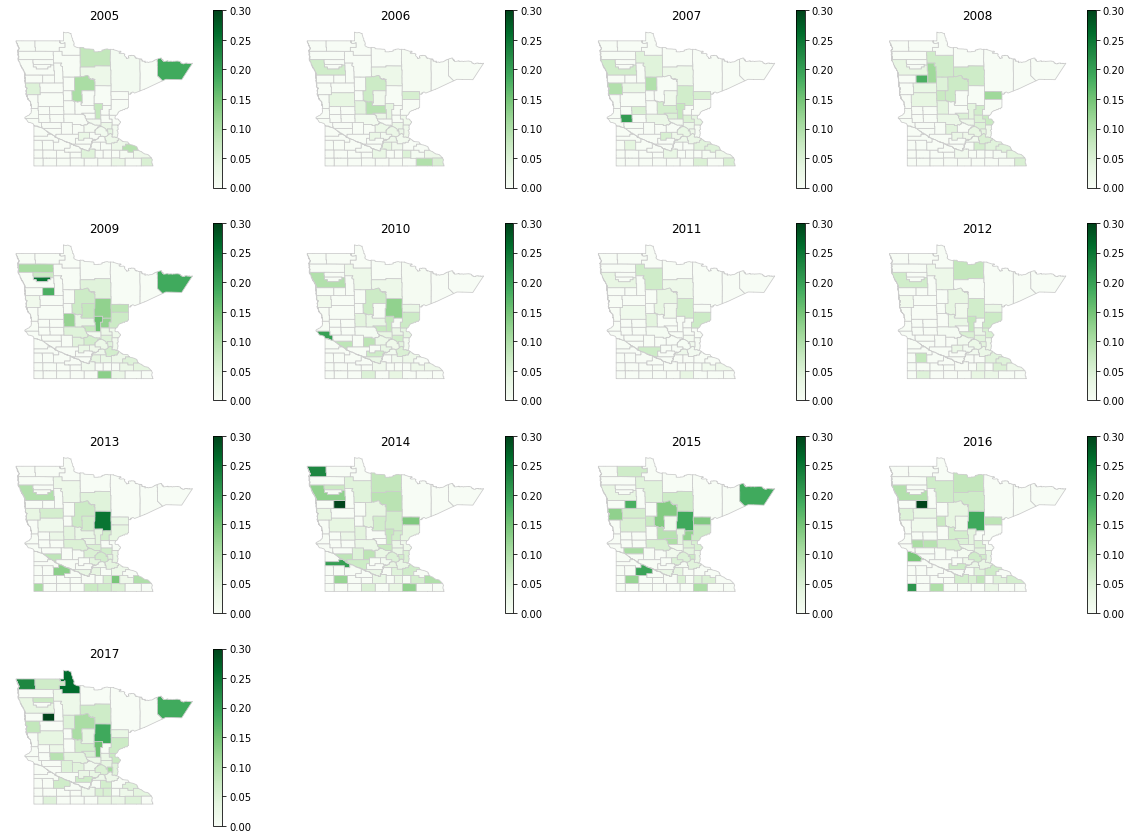

In [10]:
plt.figure(figsize=(20,15), facecolor='white')

plot_number = 1
for year in year_list:
    year = year
    # Inside of an image that's a 15x13 grid, put this
    # graph in the in the plot_number slot.
    ax = plt.subplot(4, 4, plot_number)
    vmin = 0#yr_geodeaths[year].min
    vmax = 0.3#yr_geodeaths[year].max
    
    yr_geodeaths.plot(column=year, cmap='Greens', linewidth=0.8, vmin=vmin, 
                      vmax=vmax, edgecolor='0.8',ax=ax, legend=True)
    
    ax.axis('off')
    
    ax.set_title(year, fontdict={'fontsize': '12', 'fontweight' : '3'})
    plot_number = plot_number + 1
plt